In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.path)
from eigenwell.src import grid, eigen_k, eigen_w
from eigenwell.src.constants import *

['/Users/nathanzhao/src/eigenwell/notebooks', '/Users/nathanzhao/src', '/Users/nathanzhao/opt/anaconda3/lib/python38.zip', '/Users/nathanzhao/opt/anaconda3/lib/python3.8', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nathanzhao/src/ceviche', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nathanzhao/.ipython']


(80, 80)
(6400, 6400)


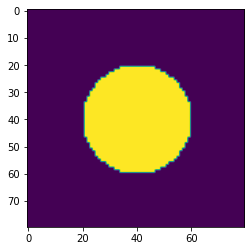

In [2]:
Nx = 80;
Ny = 80;
N = np.array([Nx, Ny]);

eps_r = np.ones(N);

a = np.array([1,1]);
dL = a/N;
radius = 0.25;
## put in a circle;
ci = int(Nx/2); cj= int(Ny/2);

cr = (radius/a[0])*Nx;
I,J=np.meshgrid(np.arange(eps_r.shape[0]),np.arange(eps_r.shape[1]));

print(eps_r.shape)
dist = np.sqrt((I-ci)**2 + (J-cj)**2);
#print(np.where(dist<cr))
eps_r[np.where(dist<cr)] = 6;

plt.imshow(eps_r)
wvlen_scan = np.linspace(1.01, 20, 100);
wvlen_scan = np.logspace(np.log10(0.8), np.log10(10), 600);


fd = grid.FiniteDifference(dL,N)

print(fd.Dxf.shape)



In [3]:
eign2d = eigen_w.EigenOmega2D(eps_r, fd);

[-1.24723939e+05+0.j  1.43511867e+18+0.j  2.56190752e+18+0.j
  3.16615133e+18+0.j  1.40815023e+18+0.j  1.40815023e+18+0.j
  4.12406066e+18+0.j  5.28768759e+18+0.j  4.58067095e+18+0.j
  4.58067095e+18+0.j]


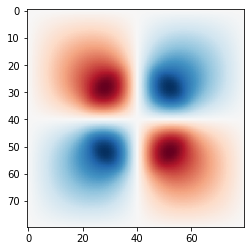

In [4]:
print(eign2d)

eigenvals, eigenvecs = eign2d.eigensolve(num_modes = 10)

print(eigenvals)

plt.imshow(np.real(np.reshape(eigenvecs[:,3], N)), cmap = 'RdBu')

## Photonic Band Structure
#### Ky = 0

In [5]:
eigk = eigen_k.EigenK2D(eps_r, fd)
print(fd.Dxf.shape)


(6400, 6400)


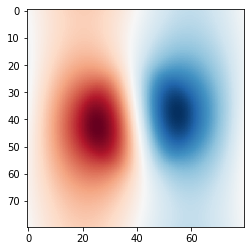

In [6]:
Ky = 0;
wvlen = 1e-6;
omega = 2*np.pi*C0/(wvlen/1e-6);
eigvals, eigvecs = eigk.eigensolve(omega, Ky)
plt.imshow(np.real(np.reshape(eigenvecs[:,5], N)), cmap = 'RdBu')

In [11]:
#wvlen_scan = np.linspace(1,10,60);
wvlen_scan = np.logspace(np.log10(1), np.log10(5),550)
spectra = [];
for c,wvlen in enumerate(wvlen_scan):
    omega = 2*np.pi*C0/(wvlen);
    eigvals, eigvecs = eigk.eigensolve(omega, Ky, num_modes = 10)
    spectra.append(eigvals);
    if(c%5 == 0):
        print(c, wvlen)
spectra = np.array(spectra)

0 1.0
5 1.0147658583811552
10 1.0297497473360429
15 1.0449548862732372
20 1.0603845421386442
25 1.0760420301174294
30 1.0919307143463142
35 1.1080540086363857
40 1.124415377206582
45 1.1410183354280075
50 1.157866450579239
55 1.174963342612783
60 1.192312684932852
65 1.2099182051846256
70 1.2277836860551634
75 1.2459129660861468
80 1.2643099404986198
85 1.2829785620299092
90 1.3019228417829012
95 1.3211468500878587
100 1.3406547173769654
105 1.3604506350717813
110 1.380538856483804
115 1.400923697728326
120 1.4216095386517866
125 1.4426008237728185
130 1.4639020632371857
135 1.4855178337868271
140 1.5074527797432038
145 1.5297116140051708
150 1.5522991190615796
155 1.575220148018835
160 1.5984796256436236
165 1.6220825494210394
170 1.6460339906283337
175 1.6703390954245196
180 1.695003085956065
185 1.7200312614789133
190 1.7454289994970709
195 1.771201756918006
200 1.7973550712251107
205 1.823894561667472
210 1.850825930467213
215 1.8781549640446618
220 1.905887534261609
225 1.93402959

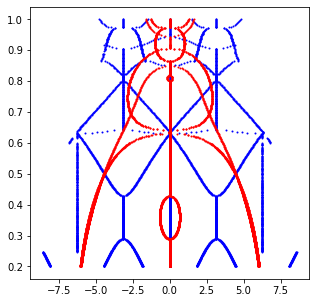

In [12]:
plt.figure(figsize = (5,5));
plt.plot(np.real(spectra), 1/wvlen_scan, '.b', markersize = 2);
plt.plot(np.imag(spectra),  1/wvlen_scan, '.r', markersize = 2);
#plt.xlim((-30e6, 50e6))
plt.show();
